In [1]:
from skimage.io import imread
from skimage.filters import gaussian
import numpy as np
from matplotlib import pyplot as plt
from skimage import img_as_float
import scipy as sp

In [2]:
cov_target = imread('./data/target.jpg') # Returns R G B image

In [3]:
cov_target.shape

(240, 320, 3)

# Covariance Tracking

Compute C_model: Good thing for us, this stuff's given right in the question.

In [4]:
modelCovMatrix = np.array([[47.917, 0, -146.636, -141.572, -123.269],
[0, 408.250, 68.487, 69.828, 53.479],
[-146.636, 68.487, 2654.285, 2621.672, 2440.381],
[-141.572, 69.828, 2621.672, 2597.818, 2435.368],
[-123.269, 53.479, 2440.381, 2435.368, 2404.923]])

Calc covariance for a given patch

`Note: Implementation detail, two things I have incorporated to speed the process up a little, I'm pre-allocating memory for feature_vec, this is faster than using append() and convert to numpy array as a new list isn't created every iteration. The other speed up is calling np.cov in return allowing it to chain with other calls, though this may not affect performance much`

In [5]:
def calc_cov(patch):
    feature_vec = np.zeros((5,patch.shape[0]*patch.shape[1]))
    for i in range(0, patch.shape[0]):
        for j in range(0, patch.shape[1]):
            feature_vec[:, (i*patch.shape[1] + j)] = np.array([i, j, patch[i, j, 0], patch[i, j, 1], patch[i, j, 2]])
    return np.cov(feature_vec, bias=True)

Calc Distance from the given model

`Similar to above, it's useful to chain function calls together, as it sees some performance benefit`

In [6]:
def cal_distance(cov_model, cov_candidate):
    ew, ev = sp.linalg.eig(cov_model, cov_candidate)
    return np.sqrt((np.log(ew)**2).sum())

Scan All the patches

In [7]:
def scan_patches(image, patch_size):
    result = []
    indices = []
    for i in range(0, image.shape[0], patch_size[0]-4):
        for j in range(0, image.shape[1], patch_size[1]-4):
            result.append(image[i:i+patch_size[0], j:j+patch_size[1]])
            indices.append((i, j))
    return result, indices

Find patch with minimum distance

We start with the minPos as (0,0) and minDist as $\infty$, and keep updating it as we scan patches. At the end, we print the patch with the lowest distance.

In [8]:
patches, indices = scan_patches(cov_target, (70, 24))

minPos = (0,0)
minDist = float("inf")

for i in range(len(patches)):
    dist = cal_distance(modelCovMatrix, calc_cov(patches[i]))
    if dist < minDist:
        minPos = indices[i]
        minDist = dist

(-0.5, 23.5, 69.5, -0.5)

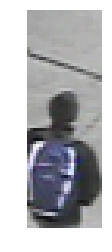

In [9]:
plt.imshow(cov_target[minPos[0]:minPos[0]+70, minPos[1]:minPos[1]+24])
plt.axis('off')

We notice that this boy with the blue bag is our mystery target! (or atleast it seems that way if everything was implemented correctly.

# Mean-shift Tracking

## Create a function to extract a feature vector for each pixel in a circular neighborhood 

In [10]:
def circularNeighbors(img, x, y, radius):
    F = np.zeros((2*radius*2*radius, 5))
    l = 0
    for i in range(-radius, radius):
        for j in range(-radius, radius):
            F[l] = (np.array([(x+i), (y+j), img[x+i,y+j, 0], img[x+i,y+j, 1], img[x+i, y+j, 2]]))
            l += 1
    return F

In [11]:
d = circularNeighbors(cov_target, 70, 44, 25)

Taking the circular neighbours of the cov_target as a test image to ensure the function doesn't have any bugs/ syntax errors.

This function should've had some array bounds detection to be "safe" and deployable, but since the image we'll be using on was bound to be sufficiently away from all these edge cases, I decided to take the easy route.

## Create a function to build a color histogram from a neighborhood of points

In [12]:
def colorHistogram(X, bins, x, y, h):
    hist = np.zeros((bins,bins,bins))
    for row in X:
        t = 1-(np.sqrt((row[0]-x)**2 + (row[1]-y)**2)/h)**2
        if t < 0:
            t = 0
        hist[int(row[2]//bins), int(row[3]//bins), int(row[4]//bins)] += t
    hist = hist/np.sum(hist)
    return hist

In [13]:
h = colorHistogram(d, 16, 70, 44, 25)

Again checking in to see if everything works as intended, nothing special

## Create a function to calculate a vector of the mean-shift weights

In [14]:
def meanShiftWeights(q_model , p_test, bins):
    w = np.zeros((bins,bins,bins))
    for i in range(bins):
        for j in range(bins):
            for k in range(bins):
                if p_test[i,j,k] == 0:
                    w[i,j,k] = 0
                else:
                    w[i,j,k] = np.sqrt(q_model[i,j,k]/p_test[i,j,k])
    return w

Since our p_test is probability and probabilties lie in the range $[0,1]$ which includes, 0, I need to perform a sanity check to avoid explosion of weights due to divide by zero.

## Use the functions above to perform mean-shift tracking

Generate Model Q

In [15]:
source = imread('./data/img1.jpg')

cNeigh = circularNeighbors(source, 150, 175, 25)
q_model = colorHistogram(cNeigh, 16, 150, 175, 25)

Calculate P at same location

In [16]:
target = imread('./data/img2.jpg')

tNeigh = circularNeighbors(target, 150, 175, 25)
p_test = colorHistogram(tNeigh, 16, 150, 175, 25)

Calculate weights

In [17]:
w = meanShiftWeights(q_model, p_test, 16)

Find best location

In [18]:
x_start = 150
y_start = 175

out_x = np.zeros((w.shape))
out_y = np.zeros((w.shape))

for i in range(-25,25):
    out_x += (x_start+i)*w
    out_y += (y_start+i)*w
    
out_x = out_x/50
out_y = out_y/50

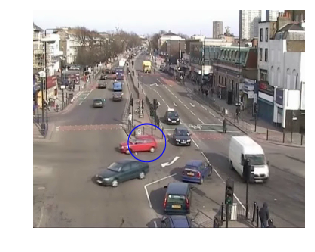

In [19]:
plt.imshow(source)
circle1 = plt.Circle((x_start, y_start), radius=25, color='b', fill=False)
plt.gcf().gca().add_artist(circle1)
plt.axis('off')
plt.show()

We can see that the red car is our target that we have to track

In [20]:
new_x = np.sum(out_x)/np.sum(w)
new_y = np.sum(out_y)/np.sum(w)

In [21]:
new_x, new_y

(149.5, 174.5)

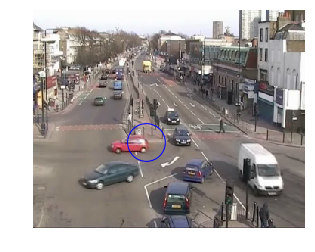

In [22]:
plt.imshow(target)
circle1 = plt.Circle((new_x, new_y), radius=25, color='b', fill=False)
plt.gcf().gca().add_artist(circle1)
plt.axis('off')
plt.show()

This part of the code was strictly, me running over the whole process once to check if the algorithm is working bug free.

Repeat for 25 iterations

In [23]:
x_0 = 150.
y_0 = 175.

for iter in range(25):
    tNeigh = circularNeighbors(target, int(x_0), int(y_0), 25)
    p_test = colorHistogram(tNeigh, 16, int(x_0), int(y_0), 25)
    w = meanShiftWeights(q_model, p_test, 16)
    out_x = np.zeros((w.shape))
    out_y = np.zeros((w.shape))
    for i in range(-25,25):
        out_x += (x_0+i)*w
        out_y += (y_0+i)*w
    out_x = out_x/50
    out_y = out_y/50
    x_0 = np.sum(out_x)/np.sum(w)
    y_0 = np.sum(out_y)/np.sum(w)
    

In [24]:
x_0,y_0

(137.50000000000003, 162.5)

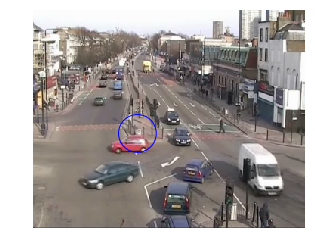

In [25]:
plt.imshow(target)
circle1 = plt.Circle((x_0, y_0), radius=25, color='b', fill=False)
plt.gcf().gca().add_artist(circle1)
plt.axis('off')
plt.show()

We notice that after 25 iterations, the tracking has done a good job following the car, but notice the center is skewed away outside the car box, this is because of drift, that we dread, maybe stopping it early would lead to a better result.